## Text Mining and Sentiment Analysis  

In [1]:
# importing the modules

import numpy as np 
import pandas as pd 
from pandas import ExcelWriter
from pandas import ExcelFile
from time import time
import re
import string
import os
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import joblib
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [41]:
# Reading the excel file "Review_Data_All.xlsx" sheet name "Review Data"
review = pd.read_excel('Review_Data_All.xlsx', sheet_name='Review Data', engine='openpyxl')

# checking the column headers
print("Column headings:",review.columns)

Column headings: Index(['Rating', 'Review Date', 'Review Paragarph', 'Review Title', 'Site'], dtype='object')


In [42]:
# dropping the unnecessary columns

review = review.drop(['Review Date', 'Review Title', 'Site'], axis=1)

In [43]:
# checking the head (i.e., the first five records of the dataframe)
review.head()

,Rating,Review Paragarph
0,1,"I went to 24/7 in the Lalit Hotel, with its fi..."
1,5,"Must visit, great staff , great managment , fo..."
2,4,Food is very good. Breakfast very good variety...
3,5,Amazing staff My purpose of visit was busines...
4,1,Hi You must be wondering why I have tested th...


In [45]:
# renaming the column "Review Paragraph" to "text"

review.rename(columns = {'Review Paragarph':'text'}, inplace = True)

In [46]:
# again checking the first five records of the "review" dataframe

review.head()

,Rating,text
0,1,"I went to 24/7 in the Lalit Hotel, with its fi..."
1,5,"Must visit, great staff , great managment , fo..."
2,4,Food is very good. Breakfast very good variety...
3,5,Amazing staff My purpose of visit was busines...
4,1,Hi You must be wondering why I have tested th...


In [47]:
# defining a class TextCounts with three methods: (i) count_regex, (ii) fit, and (iii) transfrom
# count_regex returns the length of the pattern found in the review
# fit method is used when specific operations are done on the train data but need not be 
# done on the test data

class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):        
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        
              
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           })
        
        return df
tc = TextCounts()
review_eda = tc.fit_transform(review.text)
review_eda['Rating'] = review.Rating

## Text Preprocessing - Removal of Puntutaion Marks Etc.  

In [48]:
# The class CleanText contains methods that do the basic text pre-processing
# removal of URLS, removal of punctuation marks, removal of numbers, conversion from upper case
# letters to lower case ones, removal of stopwords,stemming are done by different methods
# fit function and transform functions are used for fitting the cleaned text into the countvectorizer 
# discussed later

class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
          
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [49]:
# the cleaned text corpus is represented as ct
# a sample of five cleaned reviews (after text preprocessing) are shown
ct = CleanText()
sr_clean = ct.fit_transform(review.text)
sr_clean.sample(5)

182    delici varieti great food qualiti expect wonde...
225    excel food meal servic manag stuff happi visit...
262    waiter anil rememb abl anticip everi need chef...
50     place serv excel breakfast although not tri ma...
243    great experi lalit restaur buffet choic awesom...
Name: text, dtype: object

## Identifying the Top Temn Most Frequent Words 

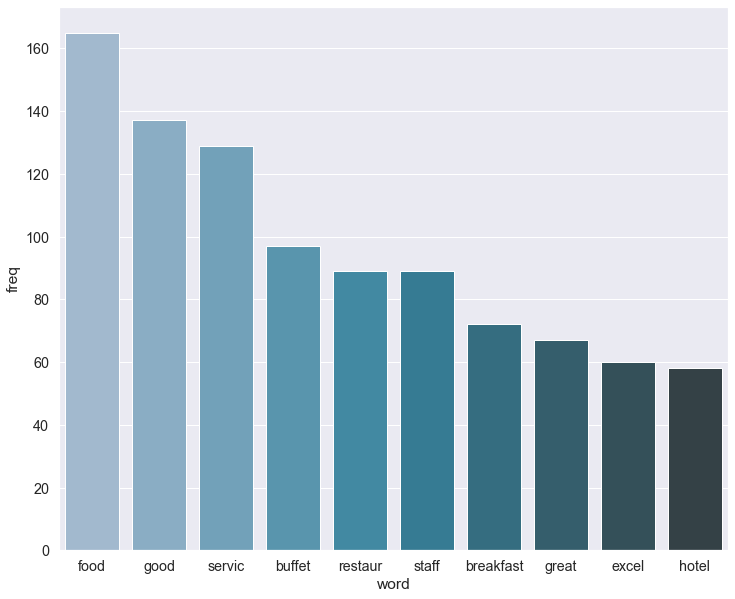

In [50]:
# The countvectorzier class constructor is invoked
# the entire cleaned text corpus is fit into the countevectorizer class 
# word_freq - a dictionary is created with the words in the text corpus (i.e., bag of words)
# word_counter - a counter for each word in the bag of words created
# word_counter_df - a pandas dataframe containing the top 10 most frequent words found in the 
# bag of words created out of the cleaned (processed) text
# barplot is created using seaborn library with the top 10 most frequent words found

cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

The top 10 most frequent words in the Review corpus are found to be: 

1. food, 
2. good, 
3. servic, 
4. buffer, 
5. restaur, 
6. staff, 
7. breakfast, 
8. great, 
9. excel, 
10. hotel

Some words are incomplete because of stemming and lemmatization 

## Computation of the Polarities in the Reviews

In [51]:
# importing the TextBlob for polarity computation

from textblob import TextBlob

In [52]:
# we extract only the polarity score and not the subjectivity score from the reviews

def sentiment_score(x):
    return TextBlob(x).polarity  

In [53]:
# we create an additional column "polarity" in the review dataframe
# The polarity column gives the polarity score of each of the reviews

review['polarity'] = review['text'].apply(sentiment_score)
 
review.head()

,Rating,text,polarity
0,1,"I went to 24/7 in the Lalit Hotel, with its fi...",0.204167
1,5,"Must visit, great staff , great managment , fo...",0.591667
2,4,Food is very good. Breakfast very good variety...,0.240357
3,5,Amazing staff My purpose of visit was busines...,0.338036
4,1,Hi You must be wondering why I have tested th...,-0.100000


## Computation of Percentage of Positive and Negative Reviews 

In [54]:
# total number of reviews in the corpus

total=len(review['polarity'])
print('Total number of reviews',total)
# counting the number of positive reviews
# assuming the lowest threshold for positive polarity as 0

pos = sum(n > 0 for n in review['polarity'])
print('Number of postive reviews',pos)

# counting the number of negative reviews
neg= sum(n <= 0 for n in review['polarity'])
print('Number of negative reviews',neg)

Total number of reviews 295
Number of postive reviews 264
Number of negative reviews 31


In [55]:
# percentage_of_positive_reviews 
print("The percentage of positive reviews: ",(pos/total))
# percentage_of_negative_reviews 
print("The percentage of negative reviews: ",(neg/total))

The percentage of positive reviews:  0.8949152542372881
The percentage of negative reviews:  0.10508474576271186


## Identifying the Most Positive, Most Negative, and Neural Reviews

In [56]:
posMax = review['polarity'].idxmax()
print("The most positive review index:",posMax)
print("Review :",review['text'][posMax])
print("Polarity :",review['polarity'][posMax])

The most positive review index: 32
Review : I Have already suggested my friends and colleagues if you visit Delhi than hotel LALIT is the best and safety place with all facilities . homely environment ,food delicious , staff and management excellent service. I can tell Delhi person also go with their family...More
Polarity : 1.0


In [57]:
posMin = review['polarity'].idxmin()
print("The most positive review index:",posMin)
print("Review :",review['text'][posMin])
print("Polarity :",review['polarity'][posMin])

The most positive review index: 156
Review : We wised to have a late night sandwich and were informed it would take a minimum of 20 minutes !!! so dropped the idea.  In the morning three of us went for our breakfast. After giving our names we were informed that it would take...More
Polarity : -0.5859375


In [58]:
neutral = review[review['polarity']==0].index.tolist()
print("The neutral review index:",neutral)
print("Review :",review['text'][neutral])
print("Polarity :",review['polarity'][neutral])

The neutral review index: [105]
Review : 105    Hungry after an exercise visited this place fo...
Name: text, dtype: object
Polarity : 105    0.0
Name: polarity, dtype: float64


## Classifying the Postive and Negative Reviews on Polarity Scores 

In [59]:
# checking the current status (i.e., the columns of the dataframe review)
review.head()

,Rating,text,polarity
0,1,"I went to 24/7 in the Lalit Hotel, with its fi...",0.204167
1,5,"Must visit, great staff , great managment , fo...",0.591667
2,4,Food is very good. Breakfast very good variety...,0.240357
3,5,Amazing staff My purpose of visit was busines...,0.338036
4,1,Hi You must be wondering why I have tested th...,-0.100000


In [60]:
# extracting the numeric fields in the dataframe
num = review._get_numeric_data()

In [61]:
num.head()

,Rating,polarity
0,1,0.204167
1,5,0.591667
2,4,0.240357
3,5,0.338036
4,1,-0.100000


In [62]:
# setting all reviews with negtaive polarity scores to "0" so that they will now belong 
# to the class "0"

num[num['polarity'] < 0] = 0

In [63]:
# setting all reviews with zero or positive polarity scores to "1" so that they will now belong 
# to the class "1"

num[num['polarity'] > 0] = 1

In [64]:
# checking the status of the review dataframe

review.head()

,Rating,text,polarity
0,1,"I went to 24/7 in the Lalit Hotel, with its fi...",1.0
1,1,"Must visit, great staff , great managment , fo...",1.0
2,1,Food is very good. Breakfast very good variety...,1.0
3,1,Amazing staff My purpose of visit was busines...,1.0
4,0,Hi You must be wondering why I have tested th...,0.0


In [65]:
# dropping the column "Rating" as it is not needed for classification
# we only need the "text" column of the review and its "polarity" (whihc is now the class label)

review = review.drop(['Rating'], axis=1)

In [66]:
# checking the first five records of the review data frame

review.head()

,text,polarity
0,"I went to 24/7 in the Lalit Hotel, with its fi...",1.0
1,"Must visit, great staff , great managment , fo...",1.0
2,Food is very good. Breakfast very good variety...,1.0
3,Amazing staff My purpose of visit was busines...,1.0
4,Hi You must be wondering why I have tested th...,0.0


## Building a Logistic Regression Model for Text Classification 

In [67]:
# preparing the countevectorizer object with a max word count of 2500 (this can be changed)
# min_df = 7, and max_df = 0.8 and stop_words remoed
# min_df = 7 implies that a word must occur in at least seven reviews in order to be counted 
# in the dictioanry. 
# max_df = 0.8 implies that any word occurring in more than 80% of the reviews will not be 
# counted in the dictionary
# the array (two dimensional), processed_feature contains the document word dictionary now

from nltk.corpus import stopwords  
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = cv.fit_transform(sr_clean).toarray()  

In [68]:
# we rename the polarity column as "labels"
labels = review.iloc[:, 1].values  

In [69]:
# the training set and the test set are created

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)  

In [70]:
# the feature sets X_Train and X-Test are standardized using MinMax standaization method

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc.fit(X_train)
S_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [71]:
#The logistic regression model is buit

from sklearn.linear_model import LogisticRegression

text_classifier = LogisticRegression()  
text_classifier.fit(X_train, y_train)  

LogisticRegression()

In [72]:
# the predictions will yield the class lables of the reviews in the test set
predictions = text_classifier.predict(X_test) 

In [73]:
# the confusion matrix and the classification reports are prepared for the LR model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))  

[[ 0  6]
 [ 1 52]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.90      0.98      0.94        53

    accuracy                           0.88        59
   macro avg       0.45      0.49      0.47        59
weighted avg       0.81      0.88      0.84        59

0.8813559322033898


In [74]:
print("Training set score: {:.3f}".format(text_classifier.score(X_train,y_train)))
print("Test set score: {:.3f}".format(text_classifier.score(X_test,y_test)))

Training set score: 0.975
Test set score: 0.881


The training accuracy of the model is: 97.5%
The test accuracy is: 88.10% 

In [75]:
# The coefficients of the logistic regression model
print(text_classifier.coef_, text_classifier.intercept_)

[[-0.09647861  0.1121197   0.11009132  0.66795421  0.11829749  0.18239942
   0.18623708  0.19099824 -0.04101084  0.43668338  0.09846685  0.54097665
   0.36032371  0.32068571  0.10687068  0.67102419  0.37490549  0.26856324
   0.27124368 -0.26156832  0.50293417  0.08824551 -0.20350312 -0.2593977
  -0.21666939 -0.0614762   0.24871643 -0.68856817 -0.63267939  0.1620187
   0.17612379  0.06366586  0.26724482  0.14464597  0.32310895  0.10541519
   0.04755445  0.06401926  0.43101664  0.35369783 -0.42955702  0.43193528
   0.0104378  -0.22086779  0.47128307  0.5872066  -0.35561524 -0.63790773
  -0.01016598  0.33603029 -0.11780135  1.07185447 -0.38169478  0.27142063
   0.689332   -0.14885875  0.48550125 -0.12372154  0.23242566  0.33788993
   0.19478524  0.09180723  0.35941598  0.46166498  0.03194775  0.02061013
   0.00493903  1.02489088  0.81527614 -0.43788474  0.12196403  0.57534152
   0.5453507  -0.01386143  0.33039667 -0.17672998 -0.25188169  0.42598734
  -0.55729906  0.14872153 -0.02381164 -0

In [76]:
np.amax(text_classifier.coef_)

1.0718544748480656

In [77]:
np.amin(text_classifier.coef_)

-1.205872435305766

The intercept of the LR model: 1.33068331
The two most significant coefficients in the model are: -1.2058724353057657 and 1.0718544748480658